[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/050_cv_segmentacion/cv_segmentacion.ipynb)

# Segmentación

Seguimos explorando diferentes aplicaciones de visión artificial. En posts anteriores hemos hablado de [localización](https://sensioai.com/blog/047_cv_loc_clas) y [detección de objetos](https://sensioai.com/blog/048_cv_detection). En este caso exploraremos la tarea de segmentación semántica, consistente en clasificar todos y cada uno de los píxeles en una imagen.

![](https://miro.medium.com/max/1575/1*kvh9u8W2sHlQoBPfwERggA.gif)

Si bien en la tarea de clasificación consiste en asignar una etiqueta a una imagen en particular, en la tarea de segmentación tendremos que asignar una etiqueta a cada pixel produciendo `mapas de segmentación`, imágenes con la misma resolución que la imagen utilizada a la entrada de nuestro modelo en la que cada pixel es sustituido por una etiqueta.

En las arquitecturas que hemos utilizado en el resto de tareas, las diferentes capas convolucionales van reduciendo el tamaño de los mapas de características (ya sea por la configuración de filtros utilizados o el uso de `pooling`). Para hacer clasificación conectamos la salida de la última capa convolucional a un `MLP` para generar las predicciones, mientras que para la detección utilizamos diferentes capas convolucionales a diferentes escalas para generar las cajas y clasificación. En el caso de la segmentación necesitamos de alguna manera recuperar las dimensiones originales de la imagen. Vamos a ver algunos ejemplos de arquitecturas que consiguen esto mismo.

## Arquitecturas

La primera idea que podemos probar es utilizar una `CNN` que no reduzca las dimensiones de los diferentes mapas de características, utilizando la correcta configuración de filtros y sin usar `pooling`. 

![](https://theaisummer.com/assets/img/posts/Semantic_Segmentation/fcn1.jpg)

Este tipo de arquitectura, sin embargo, no será capaz de extraer características a diferentes escalas y además será computacionalmente muy costos. Podemos aliviar estos problemas utilizando una arquitectura `encoder-decoder`, en la que en una primera etapa una `CNN` extrae características a diferentes escalas y luego otra `CNN` recupera las dimensiones originales.

![](https://codealogic.files.wordpress.com/2018/05/ml2.png?w=810)

Para poder utilizar este tipo de arquitecturas necesitamos alguna forma de incrementar la dimensión de un mapa de características. De entre las diferentes opciones, una muy utilizada es el uso de `convoluciones traspuestas`, una capa muy parecida a la capa convolucional que "aprende" la mejor forma de aumentar un mapa de características aplicando filtros que aumentan la resolución.

![](https://miro.medium.com/max/1972/1*kOThnLR8Fge_AJcHrkR3dg.gif)

Puedes aprender más sobre esta operación en la [documentación](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) de `Pytorch`. De esta manera podemos diseñar arquitecturas más eficientes capaces de extraer información relevante a varias escalas. Sin embargo, puede ser un poco complicado recuperar información en el `decoder` simplemente a partir de la salida del `encoder`. Para resolver este problema se desarrolló una de las arquitecturas más conocidas y utilizadas para la segmentación: la red `UNet`.

![](https://www.researchgate.net/profile/Alan_Jackson9/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png)

Esta arquitectura es muy similar a la anterior, con la diferencia de que en cada etapa del `decoder` no solo entra la salida de la capa anterior sino también la salida de la capa correspondiente del `encoder`. De esta manera la red es capaz de aprovechar mucho mejor la información a las diferentes escalas.

Vamos a ver cómo implementar esta arquitectura para hacer segmentación de MRIs.

## El Dataset

Podemos descargar un conjunto de imágenes de MRIs con sus correspondientes máscaras de segmentación usando el siguiente enlace.

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
from pycocotools.coco import COCO
from PIL import Image, ImageOps
!ls

drive  sample_data


In [42]:
import json
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
import torch
import torchvision
device = "cuda" if torch.cuda.is_available() else "cpu"

In [43]:
coco_data=COCO("/content/drive/MyDrive/SIS421/2Parcial/DataSetBasuraSegmentacion/train4/_annotations.coco.json")

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [44]:

img = coco_data.imgs[650]
img

{'id': 650,
 'license': 1,
 'file_name': 'IMG_20230523_203645_redimensionada_jpg.rf.6301d7c24719303a00bbc522270e2eaf.jpg',
 'height': 224,
 'width': 224,
 'date_captured': '2023-06-07T04:26:02+00:00'}

uint8


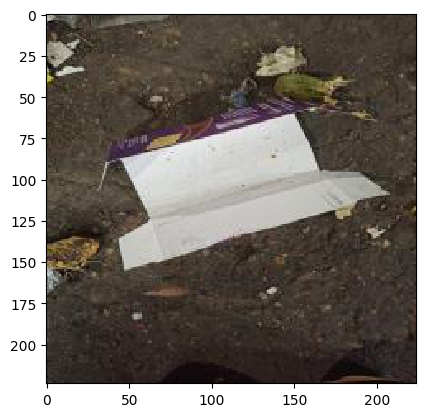

In [45]:
imagen = np.array(Image.open("/content/drive/MyDrive/SIS421/2Parcial/DataSetBasuraSegmentacion/train4/"+img['file_name']))
print(imagen.dtype)
plt.imshow(imagen, interpolation='nearest')
plt.show()

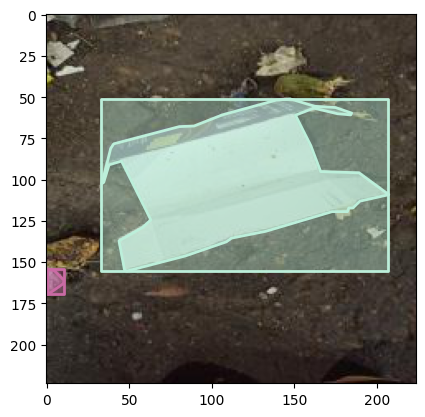

In [46]:
plt.imshow(imagen)
cat_ids = coco_data.getCatIds()
anns_ids = coco_data.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
anns = coco_data.loadAnns(anns_ids)
coco_data.showAnns(anns,draw_bbox=True)

(224, 224)


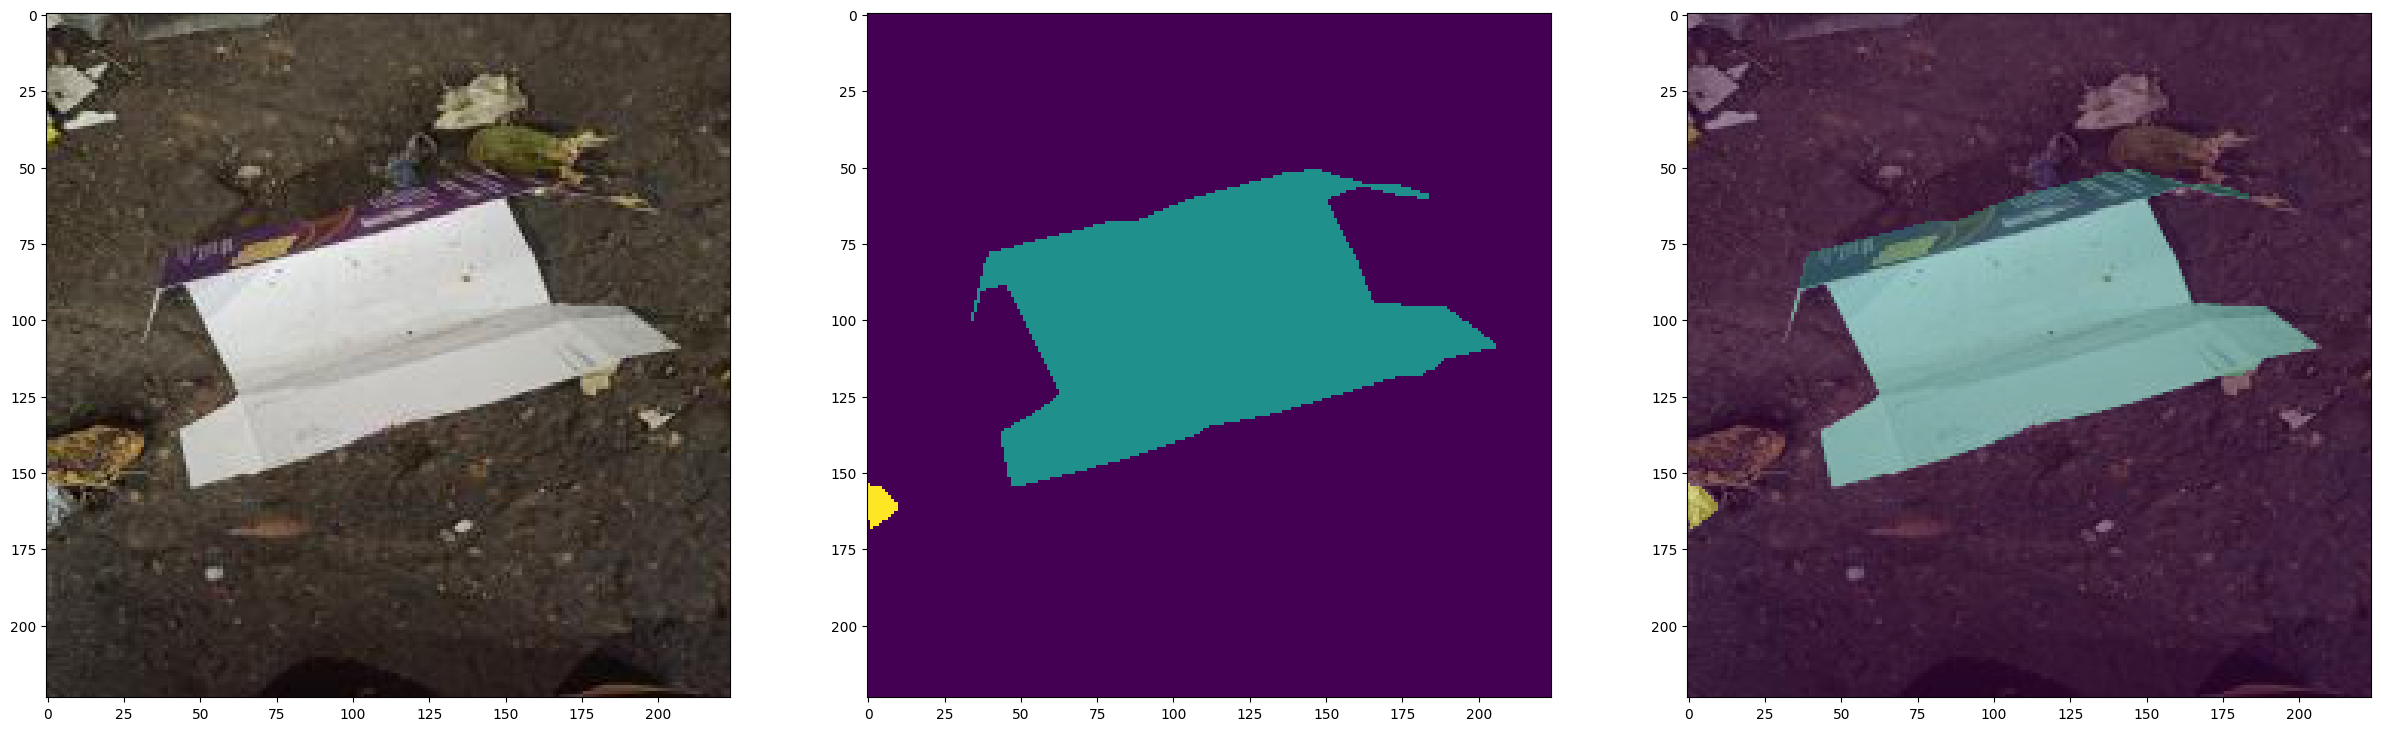

In [47]:
import matplotlib.pyplot as plt
import numpy as np

mask = coco_data.annToMask(anns[0])
print(mask.shape)
for i in range(len(anns)):
    mask += coco_data.annToMask(anns[i])
    #print(mask)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))

ax1.imshow(imagen)
ax2.imshow(mask)
ax3.imshow(imagen)
ax3.imshow(mask, alpha=0.4)
plt.show()
#plt.imshow(mask)

Nuestras imágenes tienen 394 x 394 píxeles, almacenadas como arrays de NumPy (que podemos cargar con la función np.load). Ya están normalizadas y en formato float32.

Normalizamos la imagen para que este entre 0 y 1

In [60]:
#Normalizar la imagen
imag = np.array(imagen)/255
image = imag.astype(np.float32)

In [61]:
image.shape, image.dtype, image.max(), image.min()

((224, 224, 3), dtype('float32'), 0.9843137, 0.0)

In [62]:
mask.shape, mask.dtype, mask.max(), mask.min()

((224, 224), dtype('uint8'), 2, 0)

A la hora de entrenar nuestra red necesitaremos esta máscara en formato one-hot encoding, en el que extenderemos cada pixel en una lista de longitud igual al número de clases (en este caso 3) con valores de 0 en todas las posiciones excepto en aquella que corresponda con la clase, dónde pondremos un 1.

In [63]:
mask_oh = (np.arange(3) == mask[...,None]).astype(np.float32) 

mask_oh.shape, mask_oh.dtype, mask_oh.max(), mask_oh.min()

((224, 224, 3), dtype('float32'), 1.0, 0.0)

## UNet

Vamos ahora a implementar nuestra red neuronal similar a `UNet`.

![](https://www.researchgate.net/profile/Alan_Jackson9/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png)

In [64]:
import torch.nn.functional as F

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=3):
        super().__init__()

        # lista de capas en encoder-decoder con número de filtros
        c = [16, 32, 64, 128]

        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
          conv3x3_bn(in_ch, c[0]),
          conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        # capas del decoder
        self.deconv1 = deconv(c[3],c[2])
        self.deconv2 = deconv(c[2],c[1])
        self.deconv3 = deconv(c[1],c[0])

        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)
        # decoder
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x

In [65]:
model = UNet()
output = model(torch.randn((1,3,224,224)))
output.shape

torch.Size([1, 3, 224, 224])

ENTRENAMINETO DE UNA MUESTRA

Para comprobar que todo funciona vamos a hacer el fit de una sola muestra. Para optimizar la red usamos la función de pérdida BCEWithLogitsLoss, que aplicará la función de activación sigmoid a las salidas de la red (para que estén entre 0 y 1) y luego calcula la función binary cross entropy.

In [66]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, X, y, epochs=1, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f}")

In [67]:
img_tensor = torch.tensor(image).permute(2,0,1).unsqueeze(0)
mask_tensor = torch.tensor(mask_oh).permute(2, 0, 1).unsqueeze(0)

img_tensor.shape, mask_tensor.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1, 3, 224, 224]))

In [68]:
fit(model, img_tensor, mask_tensor, epochs=20)

Epoch 1/20 loss 0.77117
Epoch 2/20 loss 0.74409
Epoch 3/20 loss 0.71980
Epoch 4/20 loss 0.70067
Epoch 5/20 loss 0.68483
Epoch 6/20 loss 0.67062
Epoch 7/20 loss 0.65718
Epoch 8/20 loss 0.64437
Epoch 9/20 loss 0.63213
Epoch 10/20 loss 0.62046
Epoch 11/20 loss 0.60934
Epoch 12/20 loss 0.59869
Epoch 13/20 loss 0.58856
Epoch 14/20 loss 0.57904
Epoch 15/20 loss 0.57000
Epoch 16/20 loss 0.56132
Epoch 17/20 loss 0.55282
Epoch 18/20 loss 0.54443
Epoch 19/20 loss 0.53600
Epoch 20/20 loss 0.52767


La función de pérdida va bajando, por lo que parece que está funcionando bien. Sin embargo, necesitamos alguna métrica para evaluar cuánto se parecen las máscaras predichas a las reales. Para ello podemos usar la métrica `IoU`, de la que ya hablamos anteriormente, y que calcula la relación entre la intersección y la unión de dos áreas.

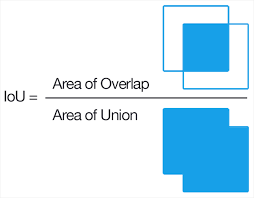

In [70]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))  
        union = (_out | _labs).float().sum((1, 2))         
        iou = (intersection + SMOOTH) / (union + SMOOTH)  
        ious.append(iou.mean().item())
    return np.mean(ious) 

In [71]:
def fit(model, X, y, epochs=1, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, y)
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f} iou {ious:.5f}")

In [72]:
fit(model, img_tensor, mask_tensor, epochs=50)

Epoch 1/50 loss 0.51955 iou 0.86804
Epoch 2/50 loss 0.49307 iou 0.88714
Epoch 3/50 loss 0.46526 iou 0.91741
Epoch 4/50 loss 0.44084 iou 0.95010
Epoch 5/50 loss 0.41918 iou 0.96853
Epoch 6/50 loss 0.39836 iou 0.96839
Epoch 7/50 loss 0.37908 iou 0.96742
Epoch 8/50 loss 0.36029 iou 0.97478
Epoch 9/50 loss 0.34250 iou 0.97497
Epoch 10/50 loss 0.32521 iou 0.97311
Epoch 11/50 loss 0.30831 iou 0.97482
Epoch 12/50 loss 0.29215 iou 0.97446
Epoch 13/50 loss 0.27715 iou 0.97253
Epoch 14/50 loss 0.26318 iou 0.97923
Epoch 15/50 loss 0.24967 iou 0.97326
Epoch 16/50 loss 0.23709 iou 0.97593
Epoch 17/50 loss 0.22545 iou 0.97894
Epoch 18/50 loss 0.21440 iou 0.97603
Epoch 19/50 loss 0.20386 iou 0.97957
Epoch 20/50 loss 0.19352 iou 0.98026
Epoch 21/50 loss 0.18395 iou 0.98062
Epoch 22/50 loss 0.17482 iou 0.98369
Epoch 23/50 loss 0.16615 iou 0.98120
Epoch 24/50 loss 0.15784 iou 0.98362
Epoch 25/50 loss 0.15022 iou 0.98537
Epoch 26/50 loss 0.14303 iou 0.98400
Epoch 27/50 loss 0.13636 iou 0.98788
Epoch 28/5

Ahora podemos generar predicciones para obtener máscaras de segmentación

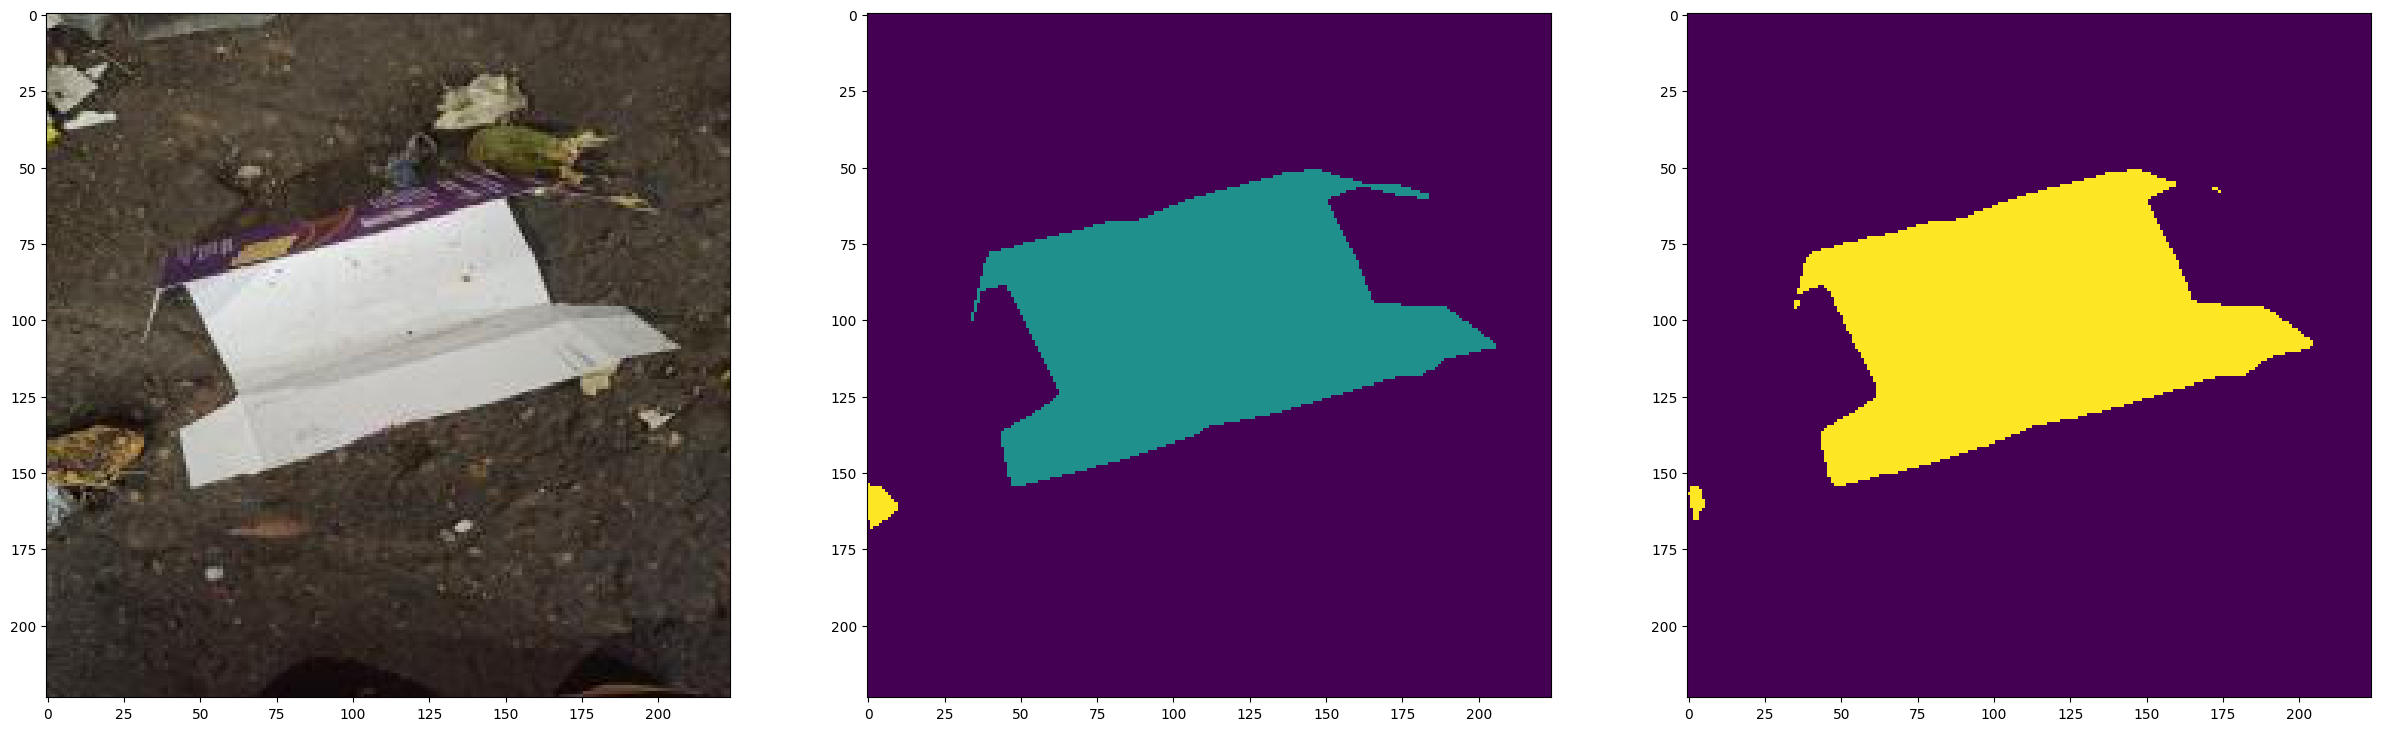

In [73]:
model.eval()
with torch.no_grad():
    output = model(img_tensor.to(device))[0]
    pred_mask = torch.argmax(output, axis=0)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(image)
ax2.imshow(mask)
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()

Entrenando con todo el dataset

Una vez hemos validado que nuestra red es capaz de hacer el fit de una imágen, podemos entrenar la red con todo el dataset.

In [87]:
from random import sample
import numpy as np
from PIL import Image

def loadImages(dataset_coco, split=0.2):
    img_test_ = []
    img_train_ = []
    mask_test_ = []
    mask_train_ = []
    labels_test_ = []
    labels_train_ = []
    data_ = dataset_coco.anns
    data = dataset_coco.imgs
    print(data)
    print(len(data_))
    test_ids = sample(list(data_.keys()), int(len(data_) * split))
    for i in data_:
        image_id_ = data_[i]['image_id']
        category = data_[i]['category_id']
        #print("las categoria",category)
        #label = category['name']
        #print("label",label)
        img_ = coco_data.imgs[image_id_]
        image_path = "/content/drive/MyDrive/SIS421/2Parcial/DataSetBasuraSegmentacion/train4/" + img_['file_name']
        image_load_ = Image.open(image_path).convert('RGB')
        image_ = np.array(image_load_) / 255
        #print(image)
        anns_ = dataset_coco.loadAnns(data_[i]['id'])

        #print(len(anns_))
        masks_ = []
        for ann in anns_:
            mask = dataset_coco.annToMask(ann)
            #print(masks)
            masks_.append(mask)
        mask_ = np.sum(masks_, axis=0)
        #print(mask)
        if i not in test_ids:
            img_train_.append(image_path)
            mask_train_.append(mask_)
            labels_train_.append(category)
        else:
            img_test_.append(image_path)
            mask_test_.append(mask_)
            labels_test_.append(category)
    return np.array(img_train_), np.array(img_test_), np.array(mask_train_), np.array(mask_test_), np.array(labels_train_), np.array(labels_test_)


In [75]:
img_train, img_test, mask_train, mask_test, labels_train ,labels_test = loadImages(coco_data, split=0.2)

{0: {'id': 0, 'license': 1, 'file_name': 'IMG_20230522_195205_redimensionada_jpg.rf.fc051b258c45a815f5fc33d60a0d9589.jpg', 'height': 224, 'width': 224, 'date_captured': '2023-06-07T04:26:02+00:00'}, 1: {'id': 1, 'license': 1, 'file_name': 'IMG_20230518_181021_redimensionada_jpg.rf.fcd231524e8a61ff138f377a4ece96f8.jpg', 'height': 224, 'width': 224, 'date_captured': '2023-06-07T04:26:02+00:00'}, 2: {'id': 2, 'license': 1, 'file_name': 'IMG_20230522_210525_redimensionada_jpg.rf.fd10099cf2355193f9f70731e278eb68.jpg', 'height': 224, 'width': 224, 'date_captured': '2023-06-07T04:26:02+00:00'}, 3: {'id': 3, 'license': 1, 'file_name': 'IMG-20230523-WA0019_redimensionada_jpg.rf.fd743f32785e34d9ea2370db07b9c306.jpg', 'height': 224, 'width': 224, 'date_captured': '2023-06-07T04:26:02+00:00'}, 4: {'id': 4, 'license': 1, 'file_name': 'IMG-20230523-WA0147_redimensionada_jpg.rf.fd902b910b8eeae62f10b0b54bfc5e4a.jpg', 'height': 224, 'width': 224, 'date_captured': '2023-06-07T04:26:02+00:00'}, 5: {'id':

In [76]:
img_train[0], img_test[0], mask_train[0].shape, mask_test[0].shape, labels_train[0].shape ,labels_test[0].shape


('/content/drive/MyDrive/SIS421/2Parcial/DataSetBasuraSegmentacion/train4/IMG_20230522_195205_redimensionada_jpg.rf.fc051b258c45a815f5fc33d60a0d9589.jpg',
 '/content/drive/MyDrive/SIS421/2Parcial/DataSetBasuraSegmentacion/train4/IMG_20230523_195636_redimensionada_jpg.rf.fc1cb1c7fecc0e860dbc6100537f3bd1.jpg',
 (224, 224),
 (224, 224),
 (),
 ())

uint8
(224, 224)


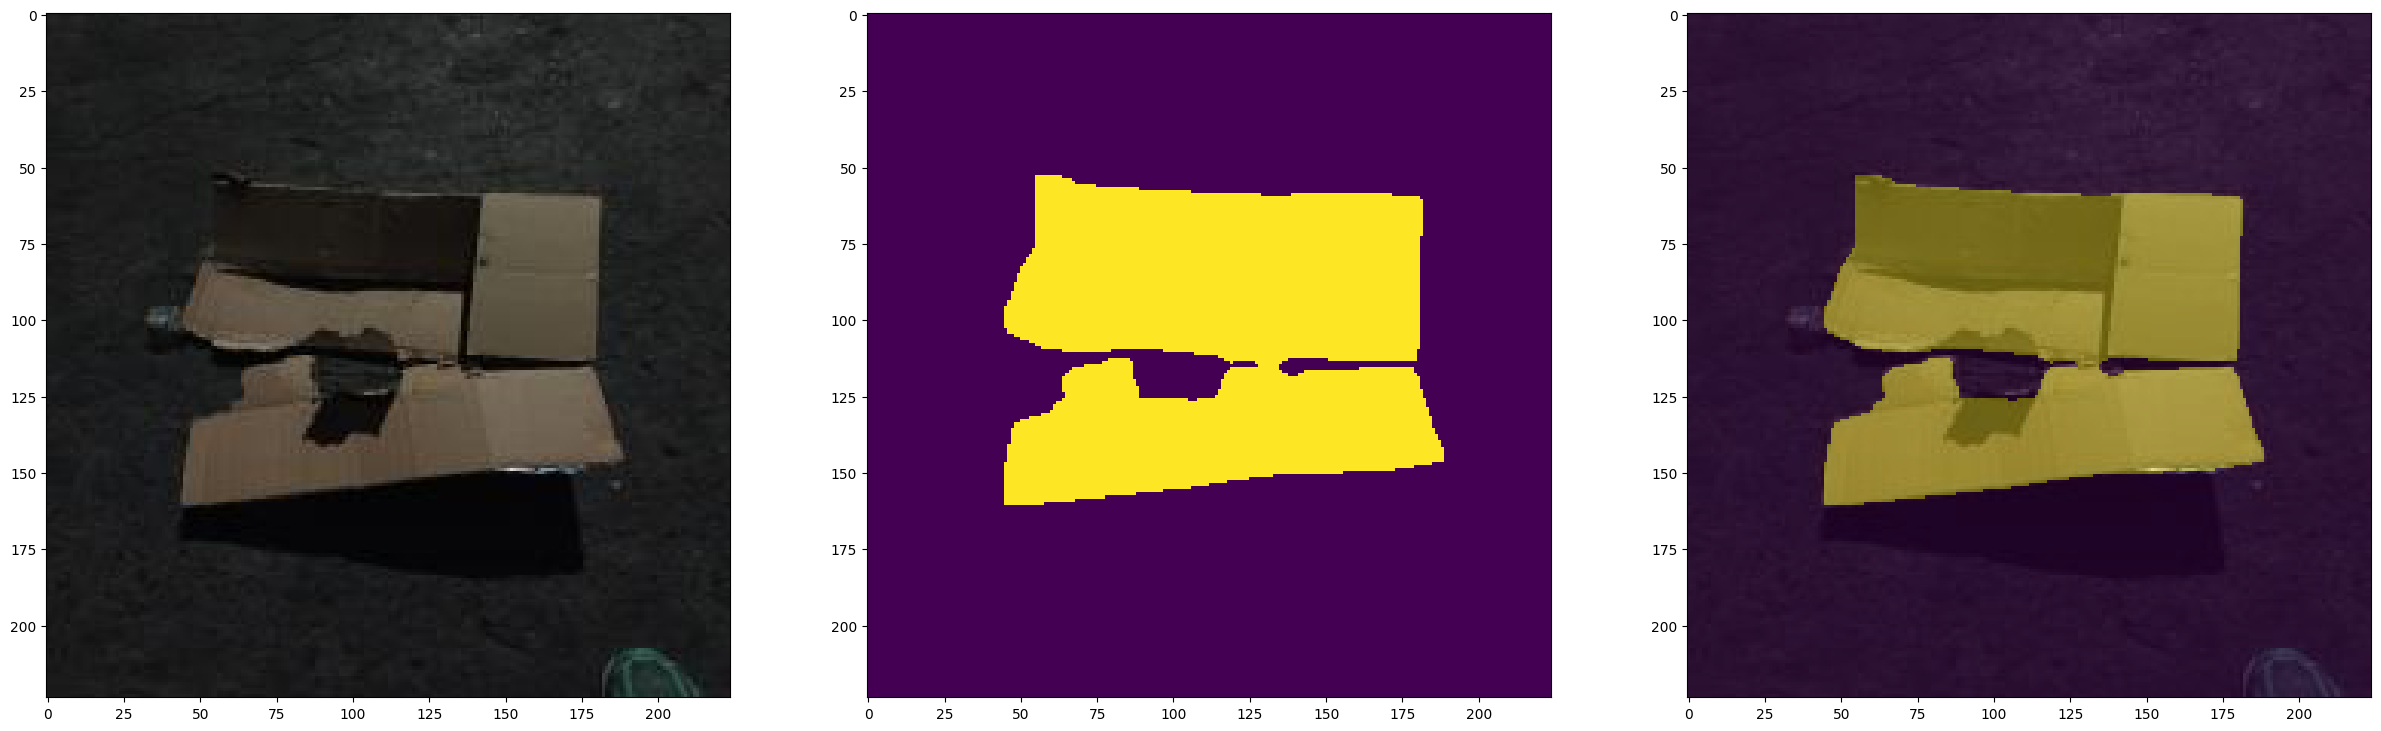

In [77]:
import matplotlib.pyplot as plt
import numpy as np
imagen = np.array(Image.open(img_test[13]))
print(imagen.dtype)
#img = imagen.astype(np.float32)
#print(imagen)
mask = mask_test[13]
print(mask.shape)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))

ax1.imshow(imagen)
ax2.imshow(mask)
ax3.imshow(imagen)
ax3.imshow(mask, alpha=0.4)
plt.show()
#plt.imshow(mask)

In [78]:
import albumentations as A
from skimage import io
from skimage import color
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, n_classes=3, transform=None):
        self.X = X
        self.y = y
        self.n_classes = n_classes
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, ix):
        #image_load = Image.open(self.X[ix]).convert('RGB')
        img = io.imread(self.X[ix])
        if img.shape[2] == 4:
            img = color.rgba2rgb(img)
        image = np.array(img) / 255
        img = image.astype(np.float32)

        mask = self.y[ix]
        img = torch.from_numpy(img).permute(2, 0, 1)
        mask = (np.arange(self.n_classes) == mask[..., None]).astype(np.float32)


        mask =torch.from_numpy(mask).permute(2, 0, 1)

        return img, mask

In [79]:
dataset = {
    'train': Dataset(img_train, mask_train),
    'test': Dataset(img_test, mask_train)
}

len(dataset['train']), len(dataset['test'])

(1496, 374)

In [80]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=16, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=16, pin_memory=True)
}
imgs, masks = next(iter(dataloader['train']))
imgs.shape, masks.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16, 3, 224, 224]))

In [81]:
from tqdm import tqdm

def fit2(model, dataloader, epochs=100, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
      bar = tqdm(dataloader['train'])
      train_loss, train_iou = [], []
      model.train()
      for imgs, masks in bar:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        y_hat = model(imgs)
        loss = criterion(y_hat, masks)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, masks)
        train_loss.append(loss.item())
        train_iou.append(ious)
        bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
      hist['loss'].append(np.mean(train_loss))
      hist['iou'].append(np.mean(train_iou))
      bar = tqdm(dataloader['test'])
      test_loss, test_iou = [], []
      model.eval()
      with torch.no_grad():
        for imgs, masks in bar:
          imgs, masks = imgs.to(device), masks.to(device)
          y_hat = model(imgs)
          loss = criterion(y_hat, masks)
          ious = iou(y_hat, masks)
          test_loss.append(loss.item())
          test_iou.append(ious)
          bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
      hist['test_loss'].append(np.mean(test_loss))
      hist['test_iou'].append(np.mean(test_iou))
      print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
    return hist

In [33]:
model = UNet()
hist = fit2(model, dataloader, epochs=3)

test_loss 0.31687 test_iou 0.44222: 100%|██████████| 24/24 [00:31<00:00,  1.31s/it]



Epoch 1/3 loss 0.45082 iou 0.47029 test_loss 0.31687 test_iou 0.44222


test_loss 0.26343 test_iou 0.44198: 100%|██████████| 24/24 [00:31<00:00,  1.33s/it]



Epoch 2/3 loss 0.22613 iou 0.44730 test_loss 0.26343 test_iou 0.44198


test_loss 0.25236 test_iou 0.44597: 100%|██████████| 24/24 [00:32<00:00,  1.34s/it]


Epoch 3/3 loss 0.17798 iou 0.45651 test_loss 0.25236 test_iou 0.44597


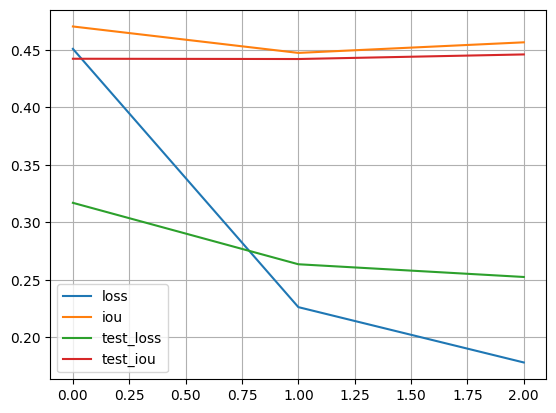

In [34]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

TRANSFER LEARNING

In [92]:
import torchvision

In [93]:
encoder = torchvision.models.densenet121(pretrained=True)
encoder

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [84]:
from re import X
import torch.nn.functional as F
import json
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
import torch
import torchvision
from torchvision import models

#device = "cuda" if torch.cuda.is_available() else "cpu"

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        x1 = F.interpolate(x1, size=x2.size()[2:], mode='bilinear', align_corners=False)  # Redimensionar x1
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

class out_conv(torch.nn.Module):
    def __init__(self, ci, co, coo):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv = conv3x3_bn(ci, co)
        self.final = torch.nn.Conv2d(co, coo, 1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = self.conv(x1)
        x = self.final(x)
        return x

class UNetDenseNet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=3):
        super(UNetDenseNet, self).__init__()
        pretrained_model = models.densenet121(pretrained=True)
        self.encoder = pretrained_model
        if in_ch != 3:
            self.encoder.features.conv0 = torch.nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.deconv1 = deconv(512, 256)
        self.deconv2 = deconv(256, 128)
        self.deconv3 = deconv(128, 64)
        self.out = out_conv(64, 64, n_classes)

    def forward(self, x):
        x_in = x.clone().detach()
        #print("",x_in.shape)
        x = self.encoder.features.conv0(x)
        #print(x.shape)
        x = self.encoder.features.norm0(x)
        #print(x.shape)
        x = self.encoder.features.relu0(x)
        #print(x.shape)
        xx = self.encoder.features.pool0(x)
        #print("xx",xx.shape)
        x1 = self.encoder.features.denseblock1(xx)
        #print("x1",x1.shape)
        x2 = self.encoder.features.transition1(x1)
        #print(x2.shape)
        x3 = self.encoder.features.denseblock2(x2)
        #print("x3",x3.shape)
        x4 = self.encoder.features.transition2(x3)
        #print("x4",x4.shape)
        x5 = self.encoder.features.denseblock3(x4)
        #print("x5",x5.shape)
        x6 = self.encoder.features.transition3(x5)
        #print("x6",x6.shape)
        x = self.deconv1(x6, x4)
        #print("a",x.shape)
        x = self.deconv2(x, x2)
        #print("b",x.shape)
        x = self.deconv3(x, xx)
        #print("c",x.shape)
        x = self.out(x, x_in)
        return x


In [85]:
import torchvision.transforms as transforms

# Define la transformación para redimensionar las imágenes al tamaño esperado (224x224)
#resize_transform = transforms.Resize((224, 224))

# Código existente para crear el modelo
densenet = UNetDenseNet()
output =densenet(torch.randn((10, 3, 224, 224)))

# Redimensiona las imágenes de entrada
#resized_images = resize_transform(input_images)

# Pasa las imágenes redimensionadas al modelo
#output = densenet(resized_images)
output.shape

torch.Size([10, 3, 224, 224])

In [86]:
hist2 = fit2(densenet, dataloader, epochs=3)

test_loss 0.41486 test_iou 0.44450: 100%|██████████| 24/24 [01:15<00:00,  3.14s/it]



Epoch 1/3 loss 0.47833 iou 0.44715 test_loss 0.41486 test_iou 0.44450


test_loss 0.33150 test_iou 0.45163: 100%|██████████| 24/24 [01:21<00:00,  3.39s/it]



Epoch 2/3 loss 0.34653 iou 0.46534 test_loss 0.33150 test_iou 0.45163


test_loss 0.29322 test_iou 0.44531: 100%|██████████| 24/24 [01:22<00:00,  3.43s/it]


Epoch 3/3 loss 0.27734 iou 0.47640 test_loss 0.29322 test_iou 0.44531


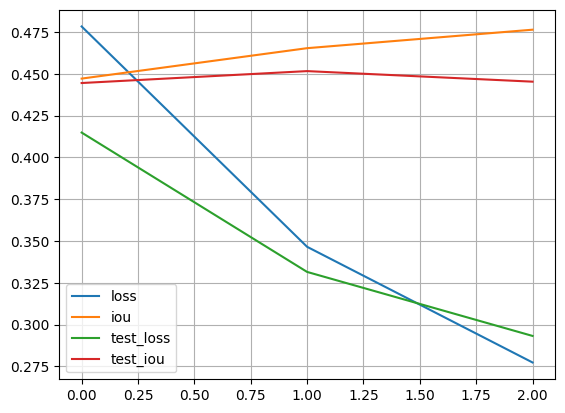

In [88]:
import pandas as pd
df = pd.DataFrame(hist2)
df.plot(grid=True)
plt.show()

In [91]:


import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
#device = torch.device('cuda')
densenet.eval()

with torch.no_grad():
    ix = random.randint(0, len(dataset['test']) - 1)
    print(ix)
    img, mask = dataset['test'][ix]
    print(img.shape)
    print(mask.shape)

    img = img.unsqueeze(0).to(device)
    print(img.shape)
    mask = mask.to(device)
    mask=mask.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    modelo_cargado = densenet.to(device)
    img_resized = F.interpolate(img, size=(224, 224), mode='bilinear', align_corners=False)
    print(img_resized.shape)
    output = modelo_cargado(img_resized)[0]

    pred_mask = torch.argmax(output, axis=0)
    # Redimensionar la máscara al tamaño de la imagen original (600x800)
    mask_resized = F.interpolate(pred_mask.unsqueeze(0).unsqueeze(0).float(), size=(224, 224), mode='nearest').squeeze().cpu().numpy()
    img = img.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # Convertir a NumPy array y transponer los ejes
# Configurar la transparencia de la máscara
colors = [(1, 1, 0, 0), (1, 1, 0, 0.4)]
cmap = LinearSegmentedColormap.from_list('CustomYellow', colors)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
ax1.imshow(img)
ax1.set_title('Imagen Original')

ax2.imshow(mask)
ax2.set_title('Máscara Original')

ax3.imshow(img)
#ax3.imshow(mask_resized, cmap='hot', alpha=0.4)
ax3.imshow(mask_resized, cmap=cmap)
ax3.set_title('Máscara Predicha')

plt.show()

310
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


RuntimeError: ignored

In [90]:
import random

densenet.eval()
with torch.no_grad():
    ix = random.randint(0, len(dataset['test'])-1)
    img, mask = dataset['test'][ix]
    img=img.squeeze(0)
    print("las",img.shape)
    print("los",mask.shape)
    output = densenet(img.unsqueeze(0).to(device))[0]
    #print(output.shape)
    pred_mask = torch.argmax(output, axis=0)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
# Transponer la imagen antes de mostrarla
image = np.transpose(img.squeeze(0).numpy(), (1, 2, 0))
print(image.shape)
ax1.imshow(image)
ax2.imshow(torch.argmax(mask, axis=0))
# Convertir la máscara en una imagen en escala de grises
mask_gray = torch.max(mask, axis=0).values
ax3.imshow(mask_gray, cmap='gray')

las torch.Size([3, 224, 224])
los torch.Size([3, 224, 224])


RuntimeError: ignored

In [ ]:
import torch
# Supongamos que tienes un modelo llamado 'model' entrenado y deseas guardarlo
torch.save(densenet.state_dict(), 'modelo_Entrenado.pth')

In [ ]:
# Crear una instancia del modelo
modelo_cargado =UNetDenseNet()
# Cargar los parámetros del modelo guardado en la instancia
modelo_cargado.load_state_dict(torch.load('/content/modelo_Entrenado.pth'))


In [ ]:
modelo_cargado.eval()

## Resumen

En este post hemos visto como podemos implementar y entrenar una red convolucional para llevar a cabo la tarea de segmentación semántica. Esta tarea consiste en clasificar todos y cada uno de los píxeles en una imagen. De esta manera podemos producir máscaras de segmentación que nos permiten localizar los diferentes objetos presentes en una imagen de forma mucho más precisa que la que podemos conseguir con la detección de objetos. Este tipo de tarea puede utilizarse en aplicaciones como la conducción autónoma o sistemas de diagnóstico médico, como hemos visto en el ejemplo de este post.